<a href="https://colab.research.google.com/github/chris-kehl/pytorch_semantic_segmentation/blob/main/pytorch_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Semantic Segmentation Introduction with Pytorch.

The first line of code will get us set up with the pytorch
environment.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from torchvision import models
from torchvision import transforms
from PIL import Image

In [3]:
# enable access the GPU
# ensure to enable runtime to GPU 
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

!nvidia-smi

Fri Jan  7 16:49:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# look at current directory
os.getcwd()

'/content'

In [5]:
# change to your working directory where you have your spider folders
os.chdir('/content/drive/MyDrive/')
os.getcwd()

'/content/drive/MyDrive'

In [6]:
# load pretrained resnet models
# Turn off specific layers for evaluation .eval()
# The model will be switched into evaluation mode
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

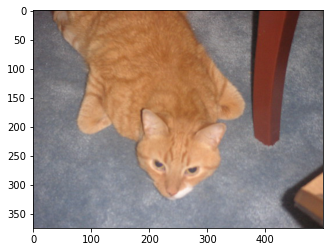

In [7]:
path = '/content/drive/MyDrive/cat_fish/train/cat/10002817_5944408634.jpg'
img = Image.open(path)
plt.imshow(img)
plt.show()

In [8]:
# create the transform which allows the model to accept the input image.
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                         std = [0.229, 0.224, 0.225])])

In [9]:
# flip and rotate images applying image augmentation
pre_img = transform(img).unsqueeze(0)

In [10]:
# pass the input through the net
out = fcn(pre_img)['out']
print(out.shape)

torch.Size([1, 21, 256, 341])


In [11]:
output_img = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (output_img.shape) # You will need the shape later to scale the other image
print (np.unique(output_img))

(256, 341)
[0 8 9]


In [12]:
# define a function
# label_colors defines the colors if the labels 1 thru 20 are found. Label 20 provides a black backgroud.
def decode_segmap(image, nc=21):
    label_colors = np.array([(0, 0, 0),# 0=background
                              (128, 0, 0), (0, 128, 0), (255, 255, 255), (0,0,128), (128, 0, 128), # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=#other
                              (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0), # 6=bus 7=car, 8=cat, 9=chair, 10=cow
                              (192, 128, 0), (64, 0 , 128), (192, 0, 128), (64, 128, 128), (192, 128, 128), # 11=dining_table, 12=dog, 13=horse, 14=other, 15=other
                              (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128) # 16=potted_plant, 17=sheep, 18=sofa, 19=train, 20=other
                              ])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb



<function matplotlib.pyplot.show>

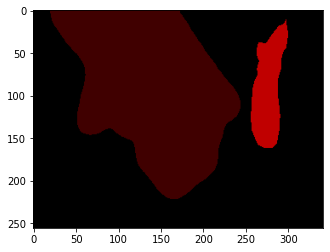

In [13]:
# call rgb to test the segmentation with our output_image
rgb = decode_segmap(output_img)
plt.imshow(rgb)
plt.show

In [14]:
# Build a function to call segment. 
def segment(net, path):
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    trf = transforms.Compose([#T.Resize(256),
                              #T.CenterCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                   std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0)
    out = net(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()


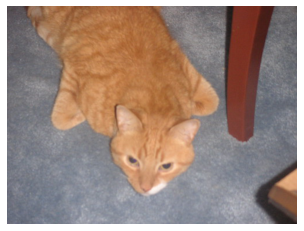

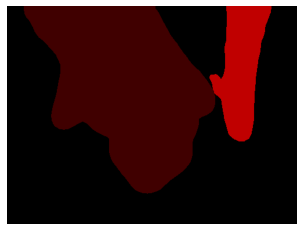

In [15]:
# calling the segment will transform our picture of the
# cat and chair of the leg 
segment(fcn, path)